In [6]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.estimator as estimator
import src.utils as utils

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the graph

In [7]:
# beta should be higher than c
n = 100 # number of nodes - 585 similar to c elegans
p = 0  # number of neighbouts to take into account
c = 1e-3 # numerator
beta = 1 # denominator
threshold = 0.5
sigma = 1.0 # from the normal DEPRECATED
n_iteration = 50
warm_up  = 2 # original 5

################################################

params_dict = {
    "n": n,
    "p": p,
    "c": c,
    "beta": beta,
    "threshold": threshold,
    "sigma": sigma,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [8]:
ut  = utils.GraphUtils()

graphs, spectra = ut.loading_graph_artifacts(params_dict)

# Estimation

In [9]:
g = graphs[-1]
s = spectra[-1]

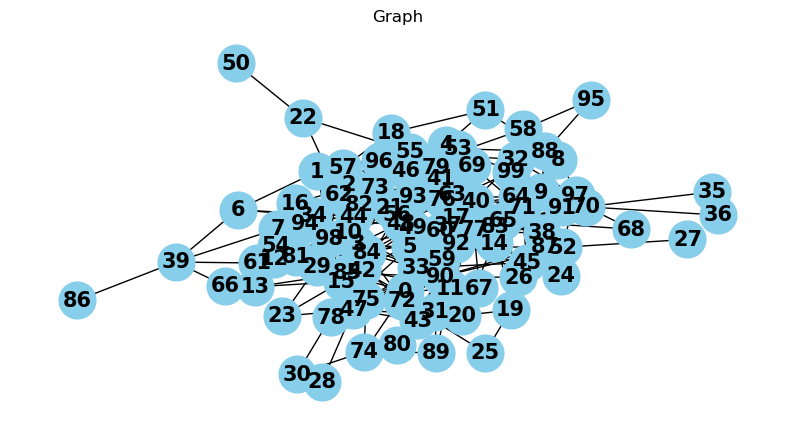

In [10]:
ut.plot_graph_from_adjacency(g, pos=None, title='Graph', size=(10,5))

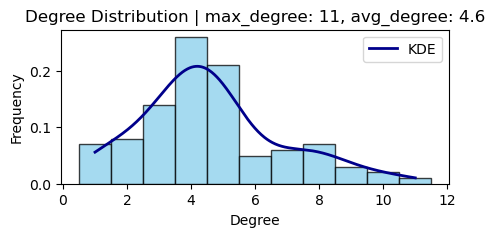

In [11]:
ut.plot_degree_distribution(g, title='Degree Distribution', size=(5,2))

In [41]:
initial_guess = [.3, .3]
est = estimator.MLEGraphModelEstimator(g)
#c_hat, beta_hat, result = est.estimate_parameters(initial_guess=initial_guess)
c_hat, beta_hat = est.estimate_parameters_torch(initial_guess=[0.5, 0.5], learning_rate=0.0005, max_iter=20)

Current parameters: c=0.3942559063434601, beta=0.5505009889602661, Loss=898.2022094726562
Current parameters: c=0.3400450348854065, beta=0.5570966005325317, Loss=878.4190063476562
Current parameters: c=0.3120712339878082, beta=0.548219621181488, Loss=873.9179077148438
Current parameters: c=0.2971213161945343, beta=0.5325350165367126, Loss=872.486572265625
Current parameters: c=0.28718361258506775, beta=0.5137104392051697, Loss=871.5655517578125
Current parameters: c=0.2785494029521942, beta=0.49311164021492004, Loss=870.644287109375
Current parameters: c=0.26986217498779297, beta=0.47107431292533875, Loss=869.6118774414062
Current parameters: c=0.26066163182258606, beta=0.44752421975135803, Loss=868.443603515625
Current parameters: c=0.25074514746665955, beta=0.42221322655677795, Loss=867.1256713867188
Current parameters: c=0.23992802202701569, beta=0.39476820826530457, Loss=865.5943603515625
Current parameters: c=0.2279771864414215, beta=0.3646572530269623, Loss=863.7525024414062
Curr

In [31]:
print(c_hat,beta_hat)
print(c,beta)
#print(result)

0.23992802202701569 0.39476820826530457
0.001 1


In [32]:
est.likelihood_function([c_hat, beta_hat]), est.likelihood_function([c, beta]), est.likelihood_function([2,0])

(-863.7651914274674, -1271.3680905754281, nan)

# Plot

In [42]:
c_values = np.linspace(0.000001, 2, 100)
beta_values = np.linspace(0.000001, 2, 100)

likelihood = np.empty((len(c_values), len(beta_values)))
for i, ci in enumerate(c_values):
    for j, betaj in enumerate(beta_values):
        likelihood[i, j] = est.likelihood_function([ci, betaj])


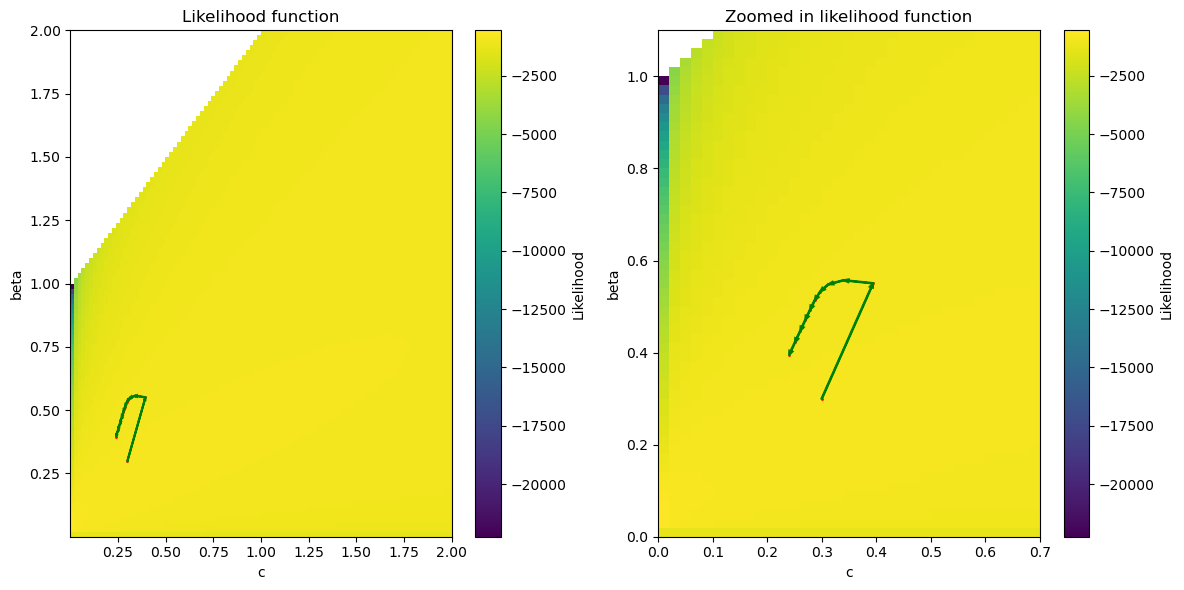

In [ ]:
params_history = np.array([initial_guess]+est.params_history)

# Convert the parameters to the corresponding indices in the c_values and beta_values arrays
c_indices = params_history[:, 0]
beta_indices = params_history[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the full heatmap on the first subplot
im = axs[0].imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
fig.colorbar(im, ax=axs[0], label='Likelihood')
axs[0].scatter(c_indices, beta_indices, color='red', s=1)  # Change color as needed
for i in range(1, len(c_indices)):
    axs[0].arrow(c_indices[i-1], beta_indices[i-1], c_indices[i]-c_indices[i-1], beta_indices[i]-beta_indices[i-1], 
              shape='full', color='green', lw=1.5, length_includes_head=True, head_width=0.006)
axs[0].set_xlabel('c')
axs[0].set_ylabel('beta')
axs[0].set_title('Likelihood function')

# Plot a zoomed in region on the second subplot
zoom_c_min, zoom_c_max = 0, 0.7  # Adjust these values to zoom in on the desired region
zoom_beta_min, zoom_beta_max = 0, 1.1  # Adjust these values to zoom in on the desired region
im_zoom = axs[1].imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
fig.colorbar(im_zoom, ax=axs[1], label='Likelihood')
axs[1].scatter(c_indices, beta_indices, color='red', s=1)  # Change color as needed
for i in range(1, len(c_indices)):
    axs[1].arrow(c_indices[i-1], beta_indices[i-1], c_indices[i]-c_indices[i-1], beta_indices[i]-beta_indices[i-1], 
              shape='full', color='green', lw=1.5, length_includes_head=True, head_width=0.006)
axs[1].set_xlim(zoom_c_min, zoom_c_max)
axs[1].set_ylim(zoom_beta_min, zoom_beta_max)
axs[1].set_xlabel('c')
axs[1].set_ylabel('beta')
axs[1].set_title('Zoomed in likelihood function')

plt.tight_layout()
plt.show()